# Image classification by multi-layer perceptron models of MNIST and Chinese MNIST datasets using TensowFlow Python

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import skimage.io
import skimage.transform

import logging
logging.getLogger("tensorflow").disabled = True

2022-06-20 21:59:04.009135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-20 21:59:04.009223: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


## MNIST

Loading initial data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

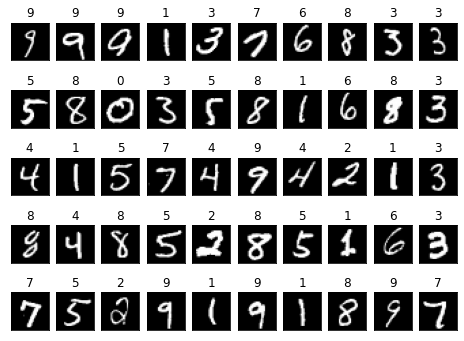

In [3]:
sample = sorted(random.sample(range(len(X_train)), 50))
fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(8, 6), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[sample[i]], cmap=plt.cm.gray)
    ax.set_title(y_train[sample[i]])
plt.show()

Data preparation for training

In [4]:
X_train = X_train.reshape(len(X_train), 784)
X_test = X_test.reshape(len(X_test), 784)

X_train = X_train.astype("float64")
X_test = X_test.astype("float64")

X_train /= 255
X_test /= 255

n_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

Splitting data into training and testing sets

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

Building a base model with a single softmax output layer

In [7]:
def basic(X):
    model = tf.layers.dense(inputs=X, units=10, kernel_initializer=tf.random.normal)
    return model

model1 = basic(X)

/tmp/ipykernel_3667/1574815626.py:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  model = tf.layers.dense(inputs=X, units=10, kernel_initializer=tf.random.normal)


Building a deep model with hidden ReLU layers

In [8]:
def relu(X):
    w1 = tf.get_variable(name="w1_relu_mnist", shape=[784, 256], initializer=tf.initializers.he_normal(), regularizer=tf.keras.regularizers.L1())
    b1 = tf.Variable(tf.zeros([256]))
    h1 = tf.nn.leaky_relu(tf.matmul(X, w1) + b1)

    w2 = tf.get_variable(name="w2_relu_mnist", shape=[256, 128], initializer=tf.initializers.he_normal(), regularizer=tf.keras.regularizers.L1())
    b2 = tf.Variable(tf.zeros([128]))
    h2 = tf.nn.elu(tf.matmul(h1, w2) + b2)

    w3 = tf.get_variable(name="w3_relu_mnist", shape=[128, 10], initializer=tf.initializers.he_normal(), regularizer=tf.keras.regularizers.L1())
    b3 = tf.Variable(tf.zeros([10]))
    model = tf.matmul(h2, w3) + b3
    
    return model

model2 = relu(X)

Building a deep model with hidden tanh layers

In [9]:
def tanh(X):
    bn0 = tf.layers.BatchNormalization()
    X = bn0.apply(X)

    bn1 = tf.layers.BatchNormalization()
    w1 = tf.get_variable(name = "w1_tanh", shape = [784, 256], initializer = tf.keras.initializers.glorot_normal())
    b1 = tf.Variable(tf.zeros([256]))
    h1 = bn1.apply(tf.nn.tanh(tf.matmul(X, w1) + b1))

    bn2 = tf.layers.BatchNormalization()
    w2 = tf.get_variable(name = "w2_tanh", shape = [256, 128], initializer = tf.keras.initializers.glorot_normal())
    b2 = tf.Variable(tf.zeros([128]))
    h2 = bn2.apply(tf.nn.tanh(tf.matmul(h1, w2) + b2))

    bn3 = tf.layers.BatchNormalization()
    w3 = tf.get_variable(name = "w3_tanh", shape = [128, 10], initializer = tf.keras.initializers.glorot_normal())
    b3 = tf.Variable(tf.zeros([10]))
    model = bn3.apply(tf.matmul(h2, w3) + b3)
    
    return model

model3 = tanh(X)

Initialization of parameters

In [10]:
learning_rate_list = [0.02, 0.04, 0.06, 0.08, 0.1]
n_epochs = 50
batch_size = 1000
n_iterations = len(X_train) // batch_size

saver = tf.train.Saver()

prediction1 = tf.equal(tf.argmax(tf.nn.softmax(model1), 1), tf.argmax(y, 1))
prediction2 = tf.equal(tf.argmax(tf.nn.softmax(model2), 1), tf.argmax(y, 1))
prediction3 = tf.equal(tf.argmax(tf.nn.softmax(model3), 1), tf.argmax(y, 1))

accuracy1 = tf.reduce_mean(tf.cast(prediction1, "float"))
accuracy2 = tf.reduce_mean(tf.cast(prediction2, "float"))
accuracy3 = tf.reduce_mean(tf.cast(prediction3, "float"))

scoring_results = pd.DataFrame(index=["F1", "AUC", "Validation accuracy"])

Training model 1 with different learning rate hyperparameters

In [11]:
acc_summary = tf.summary.scalar("Accuracy_summary_for_model1", accuracy1)
cost = tf.reduce_mean(tf.square(model1 - y))
loss_summary = tf.summary.scalar("Loss_summary_for_model1", cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for learning_rate in learning_rate_list:
    print("Learning rate %f" % learning_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        writer1 = tf.summary.FileWriter("Logs/mnist_model1_lr{}".format(learning_rate_list[0]), session.graph)
        writer2 = tf.summary.FileWriter("Logs/mnist_model1_lr{}".format(learning_rate_list[1]), session.graph)
        writer3 = tf.summary.FileWriter("Logs/mnist_model1_lr{}".format(learning_rate_list[2]), session.graph)
        writer4 = tf.summary.FileWriter("Logs/mnist_model1_lr{}".format(learning_rate_list[3]), session.graph)
        writer5 = tf.summary.FileWriter("Logs/mnist_model1_lr{}".format(learning_rate_list[4]), session.graph)
        session.run(init)
        for epoch in range(n_epochs):
            avg_loss = 0.
            start = 0; end = batch_size
            for i in range(n_iterations):
                _, loss, summary = session.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / n_iterations
            if (epoch + 1) % 10 == 0:
                print("Epoch %d. Loss = %f" % (epoch, loss))
                saver.save(session, "Checkpoints/mnist_model1_lr{}".format(learning_rate), global_step=epoch, write_meta_graph=False, write_state=False)
            cur_val_acc, summary = session.run([accuracy1, merged], feed_dict={X: X_valid, y: y_valid})
            if learning_rate == learning_rate_list[0]: writer1.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[1]: writer2.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[2]: writer3.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[3]: writer4.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[4]: writer5.add_summary(summary, epoch)
    print("")

Learning rate 0.020000


2022-06-20 21:59:13.915685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-20 21:59:13.915765: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-20 21:59:13.915802: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nightcity2): /proc/driver/nvidia/version does not exist
2022-06-20 21:59:13.916283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 21:59:14.238579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization

Epoch 9. Loss = 10.913872
Epoch 19. Loss = 7.318691
Epoch 29. Loss = 5.707665
Epoch 39. Loss = 4.748137
Epoch 49. Loss = 4.097355

Learning rate 0.040000
Epoch 9. Loss = 6.974548
Epoch 19. Loss = 4.455924
Epoch 29. Loss = 3.400367
Epoch 39. Loss = 2.784960
Epoch 49. Loss = 2.370327

Learning rate 0.060000
Epoch 9. Loss = 5.506804
Epoch 19. Loss = 3.515027
Epoch 29. Loss = 2.650702
Epoch 39. Loss = 2.144053
Epoch 49. Loss = 1.803078

Learning rate 0.080000
Epoch 9. Loss = 4.457169
Epoch 19. Loss = 2.810924
Epoch 29. Loss = 2.114102
Epoch 39. Loss = 1.702059
Epoch 49. Loss = 1.421810

Learning rate 0.100000
Epoch 9. Loss = 3.943331
Epoch 19. Loss = 2.413299
Epoch 29. Loss = 1.765861
Epoch 39. Loss = 1.391073
Epoch 49. Loss = 1.141736



Restoring the benchmark of model 1 trained at a learning rate of 0.1 at epoch 49 and saving the results

In [12]:
with tf.Session() as session:
    saver.restore(session, "Checkpoints/mnist_model1_lr0.1-49")
    preds = tf.nn.softmax(model1)
    preds_val = preds.eval({X: X_valid, y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scoring_results["model1"] = [f1_score(y_valid, preds_val, average = "macro"), roc_auc_score(y_valid, preds_val, multi_class = "ovr", average = "macro"), accuracy1.eval({X: X_valid, y: y_valid})]

Training model 2 with different learning rate hyperparameters

In [13]:
acc_summary = tf.summary.scalar("Accuracy_summary_for_model2", accuracy2)
cost = tf.reduce_mean(tf.square(model2 - y))
loss_summary = tf.summary.scalar("Loss_summary_for_model2", cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for learning_rate in learning_rate_list:
    print("Learning rate %f" % learning_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        writer1 = tf.summary.FileWriter("Logs/mnist_model2_lr{}".format(learning_rate_list[0]), session.graph)
        writer2 = tf.summary.FileWriter("Logs/mnist_model2_lr{}".format(learning_rate_list[1]), session.graph)
        writer3 = tf.summary.FileWriter("Logs/mnist_model2_lr{}".format(learning_rate_list[2]), session.graph)
        writer4 = tf.summary.FileWriter("Logs/mnist_model2_lr{}".format(learning_rate_list[3]), session.graph)
        writer5 = tf.summary.FileWriter("Logs/mnist_model2_lr{}".format(learning_rate_list[4]), session.graph)
        session.run(init)
        for epoch in range(n_epochs):
            avg_loss = 0.
            start = 0; end = batch_size
            for i in range(n_iterations):
                _, loss, summary = session.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / n_iterations
            if (epoch + 1) % 10 == 0:
                print("Epoch %d. Loss = %f" % (epoch, loss))
                saver.save(session, "Checkpoints/mnist_model2_lr{}".format(learning_rate), global_step=epoch, write_meta_graph=False, write_state=False)
            cur_val_acc, summary = session.run([accuracy2, merged], feed_dict={X: X_valid, y: y_valid})
            if learning_rate == learning_rate_list[0]: writer1.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[1]: writer2.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[2]: writer3.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[3]: writer4.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[4]: writer5.add_summary(summary, epoch)
    print("")

Learning rate 0.020000
Epoch 9. Loss = 0.061027
Epoch 19. Loss = 0.049706
Epoch 29. Loss = 0.044283
Epoch 39. Loss = 0.040822
Epoch 49. Loss = 0.038321

Learning rate 0.040000
Epoch 9. Loss = 0.050443
Epoch 19. Loss = 0.041117
Epoch 29. Loss = 0.036393
Epoch 39. Loss = 0.033275
Epoch 49. Loss = 0.031013

Learning rate 0.060000
Epoch 9. Loss = 0.043739
Epoch 19. Loss = 0.035972
Epoch 29. Loss = 0.031888
Epoch 39. Loss = 0.029142
Epoch 49. Loss = 0.027129

Learning rate 0.080000
Epoch 9. Loss = 0.041463
Epoch 19. Loss = 0.033493
Epoch 29. Loss = 0.029374
Epoch 39. Loss = 0.026761
Epoch 49. Loss = 0.024922

Learning rate 0.100000
Epoch 9. Loss = 0.039505
Epoch 19. Loss = 0.032196
Epoch 29. Loss = 0.028347
Epoch 39. Loss = 0.025849
Epoch 49. Loss = 0.024058



Restoring the benchmark of model 2 trained at a learning rate of 0.1 at epoch 49 and saving the results

In [14]:
with tf.Session() as session:
    saver.restore(session, "Checkpoints/mnist_model2_lr0.1-49")
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: X_valid, y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scoring_results["model2"] = [f1_score(y_valid, preds_val, average = "macro"), roc_auc_score(y_valid, preds_val, multi_class = "ovr", average = "macro"), accuracy2.eval({X: X_valid, y: y_valid})]

Training model 3 with different learning rate hyperparameters

In [15]:
acc_summary = tf.summary.scalar("Accuracy_summary_for_model3", accuracy3)
cost = tf.reduce_mean(tf.square(model3 - y))
loss_summary = tf.summary.scalar("Loss_summary_for_model3", cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for learning_rate in learning_rate_list:
    print("Learning rate %f" % learning_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        writer1 = tf.summary.FileWriter("Logs/mnist_model3_lr{}".format(learning_rate_list[0]), session.graph)
        writer2 = tf.summary.FileWriter("Logs/mnist_model3_lr{}".format(learning_rate_list[1]), session.graph)
        writer3 = tf.summary.FileWriter("Logs/mnist_model3_lr{}".format(learning_rate_list[2]), session.graph)
        writer4 = tf.summary.FileWriter("Logs/mnist_model3_lr{}".format(learning_rate_list[3]), session.graph)
        writer5 = tf.summary.FileWriter("Logs/mnist_model3_lr{}".format(learning_rate_list[4]), session.graph)
        session.run(init)
        for epoch in range(n_epochs):
            avg_loss = 0.
            start = 0; end = batch_size
            for i in range(n_iterations):
                _, loss, summary = session.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / n_iterations
            if (epoch + 1) % 10 == 0:
                print("Epoch %d. Loss = %f" % (epoch, loss))
                saver.save(session, "Checkpoints/mnist_model3_lr{}".format(learning_rate), global_step=epoch, write_meta_graph=False, write_state=False)
            cur_val_acc, summary = session.run([accuracy3, merged], feed_dict={X: X_valid, y: y_valid})
            if learning_rate == learning_rate_list[0]: writer1.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[1]: writer2.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[2]: writer3.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[3]: writer4.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[4]: writer5.add_summary(summary, epoch)
    print("")

Learning rate 0.020000
Epoch 9. Loss = 0.055502
Epoch 19. Loss = 0.047335
Epoch 29. Loss = 0.043381
Epoch 39. Loss = 0.040769
Epoch 49. Loss = 0.038791

Learning rate 0.040000
Epoch 9. Loss = 0.048087
Epoch 19. Loss = 0.041568
Epoch 29. Loss = 0.038013
Epoch 39. Loss = 0.035439
Epoch 49. Loss = 0.033361

Learning rate 0.060000
Epoch 9. Loss = 0.044116
Epoch 19. Loss = 0.038011
Epoch 29. Loss = 0.034289
Epoch 39. Loss = 0.031449
Epoch 49. Loss = 0.029181

Learning rate 0.080000
Epoch 9. Loss = 0.040338
Epoch 19. Loss = 0.033936
Epoch 29. Loss = 0.029974
Epoch 39. Loss = 0.027226
Epoch 49. Loss = 0.025227

Learning rate 0.100000
Epoch 9. Loss = 0.040110
Epoch 19. Loss = 0.033459
Epoch 29. Loss = 0.029243
Epoch 39. Loss = 0.026334
Epoch 49. Loss = 0.024269



Restoring the benchmark of model 3 trained at a learning rate of 0.1 at epoch 49 and saving the results

In [16]:
with tf.Session() as session:
    saver.restore(session, "Checkpoints/mnist_model3_lr0.1-49")
    preds = tf.nn.softmax(model3)
    preds_val = preds.eval({X: X_valid, y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scoring_results["model3"] = [f1_score(y_valid, preds_val, average = "macro"), roc_auc_score(y_valid, preds_val, multi_class = "ovr", average = "macro"), accuracy3.eval({X: X_valid, y: y_valid})]

Comparison of models by quality metrics F1 and AUC, and selection of the best one

In [17]:
scoring_results

,model1,model2,model3
F1,0.226524,0.922630,0.916859
AUC,0.571081,0.957090,0.953830
Validation accuracy,0.230083,0.923417,0.917500


Using model 2 to recognize 10 random images of the test set

In [18]:
with tf.Session() as session:
    saver.restore(session, "Checkpoints/mnist_model2_lr0.1-49")
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: X_test, y: y_test})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
        
sample = sorted(random.sample(range(len(X_test)), 10))
for i in range(10):
    print("valid: %d, prediction: %d" % (np.where(y_test[sample[i]]==1)[0][0], np.where(preds_val[sample[i]]==1)[0][0]))

valid: 6, prediction: 6
valid: 2, prediction: 8
valid: 4, prediction: 4
valid: 1, prediction: 1
valid: 2, prediction: 2
valid: 3, prediction: 3
valid: 3, prediction: 3
valid: 7, prediction: 7
valid: 6, prediction: 6
valid: 0, prediction: 0


Using model 2 to recognize an image created in the editor

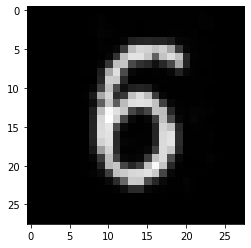

prediction: 6


In [19]:
image = skimage.io.imread("my_images/1.jpg", as_gray=True)
image = skimage.transform.resize(image, (28, 28), mode="reflect")

plt.imshow(image, cmap=plt.cm.gray)
plt.show()

image = image.reshape(1, 784)
image = image.astype("float64")

with tf.Session() as session:
    saver.restore(session, "Checkpoints/mnist_model2_lr0.1-49")
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: image})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)

print("prediction: %d" % (np.where(preds_val[0]==1)[0][0]))

## Chinese MNIST

Loading initial data

In [20]:
data = pd.read_csv("chinese_mnist/chinese_mnist.csv")
characters = ["一", "七", "万", "三", "九", "二", "五", "亿", "八", "六", "十", "千", "四", "百", "零", ]

def create_file_name(df):
    file_name = f"input_{df[0]}_{df[1]}_{df[2]}.jpg"
    return file_name

def read_image(file_name):
    image = skimage.io.imread("chinese_mnist/data/data/" + file_name)
    image = skimage.transform.resize(image, (64, 64), mode="reflect")
    return image[:, :]

def character_encoder(data, var="character"):
    X = np.stack(data["file"].apply(read_image))
    y = pd.get_dummies(data[var], drop_first=False).to_numpy()
    return X, y

data["file"] = data.apply(create_file_name, axis=1)

X, y = character_encoder(data)

character: 十


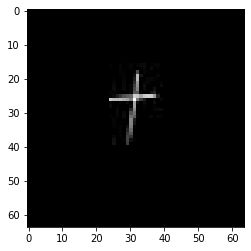

character: 百


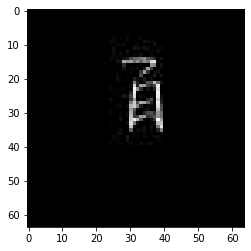

character: 千


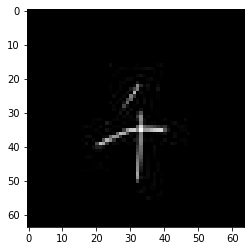

character: 亿


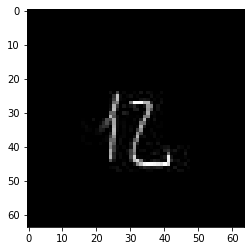

character: 二


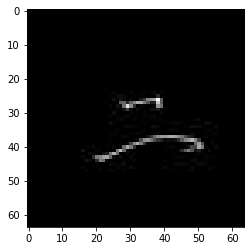

character: 三


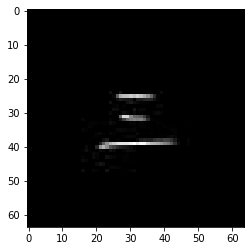

character: 五


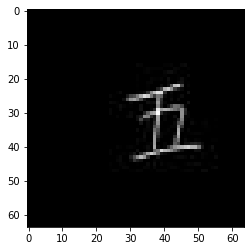

character: 七


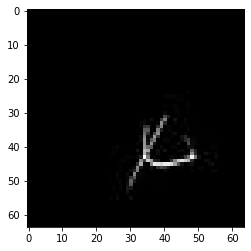

character: 八


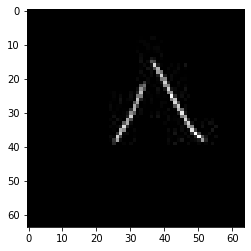

character: 八


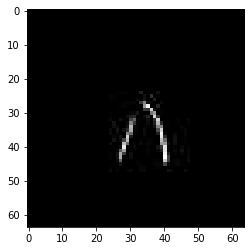

In [21]:
sample = sorted(random.sample(range(len(X)), 10))
for i in range(10):
    print("character: %s" % (characters[np.where(y[sample[i]]==1)[0][0]]))
    plt.imshow(X[sample[i]], cmap=plt.cm.gray)
    plt.show()

Data preparation for training

In [22]:
X = X.reshape(len(X), 4096)
X = X.astype("float64")

Splitting data into training and testing sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [24]:
X = tf.placeholder(tf.float32, shape=[None, 4096])
y = tf.placeholder(tf.float32, shape=[None, 15])

Building a base model with a single softmax output layer

In [25]:
def basic(X):
    model = tf.layers.dense(inputs=X, units=15, kernel_initializer=tf.random.normal)
    return model

model1 = basic(X)

/tmp/ipykernel_3667/1860730385.py:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  model = tf.layers.dense(inputs=X, units=15, kernel_initializer=tf.random.normal)


Building a deep model with hidden ReLU layers

In [28]:
def relu(X):
    w1 = tf.get_variable(name="w1_relu_chinese_mnist", shape=[4096, 256], initializer=tf.initializers.he_normal(), regularizer=tf.keras.regularizers.L1())
    b1 = tf.Variable(tf.zeros([256]))
    h1 = tf.nn.leaky_relu(tf.matmul(X, w1) + b1)

    w2 = tf.get_variable(name="w2_relu_chinese_mnist", shape=[256, 128], initializer=tf.initializers.he_normal(), regularizer=tf.keras.regularizers.L1())
    b2 = tf.Variable(tf.zeros([128]))
    h2 = tf.nn.elu(tf.matmul(h1, w2) + b2)

    w3 = tf.get_variable(name="w3_relu_chinese_mnist", shape=[128, 15], initializer=tf.initializers.he_normal(), regularizer=tf.keras.regularizers.L1())
    b3 = tf.Variable(tf.zeros([15]))
    model = tf.matmul(h2, w3) + b3
    
    return model

model2 = relu(X)

Building a deep model with hidden tanh layers

In [29]:
def tanh(X):
    bn0 = tf.layers.BatchNormalization()
    X = bn0.apply(X)

    bn1 = tf.layers.BatchNormalization()
    w1 = tf.get_variable(name = "w1_tanh_chinese_mnist", shape = [4096, 256], initializer = tf.keras.initializers.glorot_normal())
    b1 = tf.Variable(tf.zeros([256]))
    h1 = bn1.apply(tf.nn.tanh(tf.matmul(X, w1) + b1))

    bn2 = tf.layers.BatchNormalization()
    w2 = tf.get_variable(name = "w2_tanh_chinese_mnist", shape = [256, 128], initializer = tf.keras.initializers.glorot_normal())
    b2 = tf.Variable(tf.zeros([128]))
    h2 = bn2.apply(tf.nn.tanh(tf.matmul(h1, w2) + b2))

    bn3 = tf.layers.BatchNormalization()
    w3 = tf.get_variable(name = "w3_tanh_chinese_mnist", shape = [128, 15], initializer = tf.keras.initializers.glorot_normal())
    b3 = tf.Variable(tf.zeros([15]))
    model = bn3.apply(tf.matmul(h2, w3) + b3)
    
    return model

model3 = tanh(X)

Initialization of parameters

In [30]:
learning_rate_list = [0.02, 0.04, 0.06, 0.08, 0.1]
n_epochs = 50
batch_size = 1000
n_iterations = len(X_train) // batch_size

saver = tf.train.Saver()

prediction1 = tf.equal(tf.argmax(tf.nn.softmax(model1), 1), tf.argmax(y, 1))
prediction2 = tf.equal(tf.argmax(tf.nn.softmax(model2), 1), tf.argmax(y, 1))
prediction3 = tf.equal(tf.argmax(tf.nn.softmax(model3), 1), tf.argmax(y, 1))

accuracy1 = tf.reduce_mean(tf.cast(prediction1, "float"))
accuracy2 = tf.reduce_mean(tf.cast(prediction2, "float"))
accuracy3 = tf.reduce_mean(tf.cast(prediction3, "float"))

scoring_results = pd.DataFrame(index=["F1", "AUC", "Validation accuracy"])

Training model 1 with different learning rate hyperparameters

In [31]:
acc_summary = tf.summary.scalar("Accuracy_summary_for_model1", accuracy1)
cost = tf.reduce_mean(tf.square(model1 - y))
loss_summary = tf.summary.scalar("Loss_summary_for_model1", cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for learning_rate in learning_rate_list:
    print("Learning rate %f" % learning_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        writer1 = tf.summary.FileWriter("Logs/chinese_mnist_model1_lr{}".format(learning_rate_list[0]), session.graph)
        writer2 = tf.summary.FileWriter("Logs/chinese_mnist_model1_lr{}".format(learning_rate_list[1]), session.graph)
        writer3 = tf.summary.FileWriter("Logs/chinese_mnist_model1_lr{}".format(learning_rate_list[2]), session.graph)
        writer4 = tf.summary.FileWriter("Logs/chinese_mnist_model1_lr{}".format(learning_rate_list[3]), session.graph)
        writer5 = tf.summary.FileWriter("Logs/chinese_mnist_model1_lr{}".format(learning_rate_list[4]), session.graph)
        session.run(init)
        for epoch in range(n_epochs):
            avg_loss = 0.
            start = 0; end = batch_size
            for i in range(n_iterations):
                _, loss, summary = session.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / n_iterations
            if (epoch + 1) % 10 == 0:
                print("Epoch %d. Loss = %f" % (epoch, loss))
                saver.save(session, "Checkpoints/chinese_mnist_model1_lr{}".format(learning_rate), global_step=epoch, write_meta_graph=False, write_state=False)
            cur_val_acc, summary = session.run([accuracy1, merged], feed_dict={X: X_valid, y: y_valid})
            if learning_rate == learning_rate_list[0]: writer1.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[1]: writer2.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[2]: writer3.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[3]: writer4.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[4]: writer5.add_summary(summary, epoch)
    print("")

Learning rate 0.020000
Epoch 9. Loss = 11.264481
Epoch 19. Loss = 10.680971
Epoch 29. Loss = 10.329950
Epoch 39. Loss = 10.051865
Epoch 49. Loss = 9.803626

Learning rate 0.040000
Epoch 9. Loss = 10.747039
Epoch 19. Loss = 10.133382
Epoch 29. Loss = 9.682755
Epoch 39. Loss = 9.286201
Epoch 49. Loss = 8.929350

Learning rate 0.060000
Epoch 9. Loss = 10.258922
Epoch 19. Loss = 9.497406
Epoch 29. Loss = 8.884541
Epoch 39. Loss = 8.361773
Epoch 49. Loss = 7.910751

Learning rate 0.080000
Epoch 9. Loss = 9.889858
Epoch 19. Loss = 8.972067
Epoch 29. Loss = 8.251776
Epoch 39. Loss = 7.665609
Epoch 49. Loss = 7.178848

Learning rate 0.100000
Epoch 9. Loss = 9.506683
Epoch 19. Loss = 8.507816
Epoch 29. Loss = 7.750424
Epoch 39. Loss = 7.154948
Epoch 49. Loss = 6.673036



Restoring the benchmark of model 1 trained at a learning rate of 0.1 at epoch 49 and saving the results

In [32]:
with tf.Session() as session:
    saver.restore(session, "Checkpoints/chinese_mnist_model1_lr0.1-49")
    preds = tf.nn.softmax(model1)
    preds_val = preds.eval({X: X_valid, y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scoring_results["model1"] = [f1_score(y_valid, preds_val, average = "macro"), roc_auc_score(y_valid, preds_val, multi_class = "ovr", average = "macro"), accuracy1.eval({X: X_valid, y: y_valid})]

Training model 2 with different learning rate hyperparameters

In [33]:
acc_summary = tf.summary.scalar("Accuracy_summary_for_model2", accuracy2)
cost = tf.reduce_mean(tf.square(model2 - y))
loss_summary = tf.summary.scalar("Loss_summary_for_model2", cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for learning_rate in learning_rate_list:
    print("Learning rate %f" % learning_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        writer1 = tf.summary.FileWriter("Logs/chinese_mnist_model2_lr{}".format(learning_rate_list[0]), session.graph)
        writer2 = tf.summary.FileWriter("Logs/chinese_mnist_model2_lr{}".format(learning_rate_list[1]), session.graph)
        writer3 = tf.summary.FileWriter("Logs/chinese_mnist_model2_lr{}".format(learning_rate_list[2]), session.graph)
        writer4 = tf.summary.FileWriter("Logs/chinese_mnist_model2_lr{}".format(learning_rate_list[3]), session.graph)
        writer5 = tf.summary.FileWriter("Logs/chinese_mnist_model2_lr{}".format(learning_rate_list[4]), session.graph)
        session.run(init)
        for epoch in range(n_epochs):
            avg_loss = 0.
            start = 0; end = batch_size
            for i in range(n_iterations):
                _, loss, summary = session.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / n_iterations
            if (epoch + 1) % 10 == 0:
                print("Epoch %d. Loss = %f" % (epoch, loss))
                saver.save(session, "Checkpoints/chinese_mnist_model2_lr{}".format(learning_rate), global_step=epoch, write_meta_graph=False, write_state=False)
            cur_val_acc, summary = session.run([accuracy2, merged], feed_dict={X: X_valid, y: y_valid})
            if learning_rate == learning_rate_list[0]: writer1.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[1]: writer2.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[2]: writer3.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[3]: writer4.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[4]: writer5.add_summary(summary, epoch)
    print("")

Learning rate 0.020000
Epoch 9. Loss = 0.070891
Epoch 19. Loss = 0.069134
Epoch 29. Loss = 0.067810
Epoch 39. Loss = 0.066680
Epoch 49. Loss = 0.065701

Learning rate 0.040000
Epoch 9. Loss = 0.067758
Epoch 19. Loss = 0.065792
Epoch 29. Loss = 0.064272
Epoch 39. Loss = 0.063046
Epoch 49. Loss = 0.062031

Learning rate 0.060000
Epoch 9. Loss = 0.066462
Epoch 19. Loss = 0.064024
Epoch 29. Loss = 0.062268
Epoch 39. Loss = 0.060939
Epoch 49. Loss = 0.059885

Learning rate 0.080000
Epoch 9. Loss = 0.064807
Epoch 19. Loss = 0.062159
Epoch 29. Loss = 0.060411
Epoch 39. Loss = 0.059135
Epoch 49. Loss = 0.058140

Learning rate 0.100000
Epoch 9. Loss = 0.064847
Epoch 19. Loss = 0.061709
Epoch 29. Loss = 0.059720
Epoch 39. Loss = 0.058285
Epoch 49. Loss = 0.057171



Restoring the benchmark of model 2 trained at a learning rate of 0.1 at epoch 49 and saving the results

In [34]:
with tf.Session() as session:
    saver.restore(session, "Checkpoints/chinese_mnist_model2_lr0.1-49")
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: X_valid, y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scoring_results["model2"] = [f1_score(y_valid, preds_val, average = "macro"), roc_auc_score(y_valid, preds_val, multi_class = "ovr", average = "macro"), accuracy2.eval({X: X_valid, y: y_valid})]

Training model 3 with different learning rate hyperparameters

In [35]:
acc_summary = tf.summary.scalar("Accuracy_summary_for_model3", accuracy3)
cost = tf.reduce_mean(tf.square(model3 - y))
loss_summary = tf.summary.scalar("Loss_summary_for_model3", cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for learning_rate in learning_rate_list:
    print("Learning rate %f" % learning_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        writer1 = tf.summary.FileWriter("Logs/chinese_mnist_model3_lr{}".format(learning_rate_list[0]), session.graph)
        writer2 = tf.summary.FileWriter("Logs/chinese_mnist_model3_lr{}".format(learning_rate_list[1]), session.graph)
        writer3 = tf.summary.FileWriter("Logs/chinese_mnist_model3_lr{}".format(learning_rate_list[2]), session.graph)
        writer4 = tf.summary.FileWriter("Logs/chinese_mnist_model3_lr{}".format(learning_rate_list[3]), session.graph)
        writer5 = tf.summary.FileWriter("Logs/chinese_mnist_model3_lr{}".format(learning_rate_list[4]), session.graph)
        session.run(init)
        for epoch in range(n_epochs):
            avg_loss = 0.
            start = 0; end = batch_size
            for i in range(n_iterations):
                _, loss, summary = session.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / n_iterations
            if (epoch + 1) % 10 == 0:
                print("Epoch %d. Loss = %f" % (epoch, loss))
                saver.save(session, "Checkpoints/chinese_mnist_model3_lr{}".format(learning_rate), global_step=epoch, write_meta_graph=False, write_state=False)
            cur_val_acc, summary = session.run([accuracy3, merged], feed_dict={X: X_valid, y: y_valid})
            if learning_rate == learning_rate_list[0]: writer1.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[1]: writer2.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[2]: writer3.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[3]: writer4.add_summary(summary, epoch)
            if learning_rate == learning_rate_list[4]: writer5.add_summary(summary, epoch)
    print("")

Learning rate 0.020000
Epoch 9. Loss = 0.071299
Epoch 19. Loss = 0.069189
Epoch 29. Loss = 0.067542
Epoch 39. Loss = 0.066208
Epoch 49. Loss = 0.065099

Learning rate 0.040000
Epoch 9. Loss = 0.068004
Epoch 19. Loss = 0.065288
Epoch 29. Loss = 0.063399
Epoch 39. Loss = 0.062003
Epoch 49. Loss = 0.060922

Learning rate 0.060000
Epoch 9. Loss = 0.067703
Epoch 19. Loss = 0.064412
Epoch 29. Loss = 0.062274
Epoch 39. Loss = 0.060757
Epoch 49. Loss = 0.059610

Learning rate 0.080000
Epoch 9. Loss = 0.066679
Epoch 19. Loss = 0.062877
Epoch 29. Loss = 0.060649
Epoch 39. Loss = 0.059141
Epoch 49. Loss = 0.058026

Learning rate 0.100000
Epoch 9. Loss = 0.064746
Epoch 19. Loss = 0.061319
Epoch 29. Loss = 0.059332
Epoch 39. Loss = 0.057974
Epoch 49. Loss = 0.056961



Restoring the benchmark of model 3 trained at a learning rate of 0.1 at epoch 49 and saving the results

In [36]:
with tf.Session() as session:
    saver.restore(session, "Checkpoints/chinese_mnist_model3_lr0.1-49")
    preds = tf.nn.softmax(model3)
    preds_val = preds.eval({X: X_valid, y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scoring_results["model3"] = [f1_score(y_valid, preds_val, average = "macro"), roc_auc_score(y_valid, preds_val, multi_class = "ovr", average = "macro"), accuracy3.eval({X: X_valid, y: y_valid})]

Comparison of models by quality metrics F1 and AUC, and selection of the best one

In [37]:
scoring_results

,model1,model2,model3
F1,0.060983,0.275239,0.294262
AUC,0.497184,0.626043,0.636849
Validation accuracy,0.061667,0.296667,0.317083


Using model 2 to recognize 10 random images of the test set

In [38]:
with tf.Session() as session:
    saver.restore(session, "Checkpoints/chinese_mnist_model2_lr0.1-49")
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: X_test, y: y_test})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
        
sample = sorted(random.sample(range(len(X_test)), 10))
for i in range(10):
    print("valid: %s, prediction: %s" % (characters[np.where(y_test[sample[i]]==1)[0][0]], characters[np.where(preds_val[sample[i]]==1)[0][0]]))

valid: 八, prediction: 六
valid: 万, prediction: 百
valid: 千, prediction: 零
valid: 八, prediction: 八
valid: 三, prediction: 八
valid: 二, prediction: 六
valid: 四, prediction: 九
valid: 零, prediction: 五
valid: 七, prediction: 一
valid: 一, prediction: 一


Using model 2 to recognize an image created in the editor

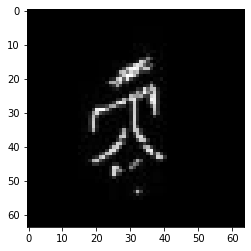

prediction: 零


In [39]:
image = skimage.io.imread("my_images/2.jpg", as_gray=True)
image = skimage.transform.resize(image, (64, 64), mode="reflect")

plt.imshow(image, cmap=plt.cm.gray)
plt.show()

image = image.reshape(1, 4096)
image = image.astype("float64")

with tf.Session() as session:
    saver.restore(session, "Checkpoints/chinese_mnist_model2_lr0.1-49")
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: image})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
        
print("prediction: %s" % (characters[np.where(preds_val[0]==1)[0][0]]))